In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# X = np.load('X_3_classes.npy')
# y = np.load('y_3_classes.npy')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# X_train.shape, y_train.shape, X_val.shape

In [6]:
from birds_utils import DataGenerator

dataset_folder_train = './dataset/train/'
dataset_folder_val = './dataset/val/'
dgen_train = DataGenerator(dataset_folder_train, batch_size=128)
dgen_val = DataGenerator(dataset_folder_val, batch_size=128)

In [7]:
for x, c in dgen_train:
    print(x.shape, c.shape)
    break

(128, 44100, 1) (128, 3)


In [8]:
len(dgen_train), len(dgen_val)

(67, 17)

In [9]:
# del X, y

In [10]:
def get_fourier_weights(window_size):
    frec = np.linspace(-window_size//2, window_size//2-1, window_size)
    time = np.linspace(0, window_size-1, window_size)
    hanning_window = np.hanning(window_size)

    filters_cos = []
    filters_sin = []
    for i in range(window_size//2):
        filters_cos.append(np.cos(2*np.pi*frec[i]*time/window_size))
        filters_sin.append(np.sin(2*np.pi*frec[i]*time/window_size))
    filters_cos = np.array(filters_cos)[::-1]*hanning_window
    filters_sin = np.array(filters_sin)[::-1]*hanning_window
    return filters_cos, filters_sin

def set_cnn_weights(model, filters_cos, filters_sin, cos_layer='cos', sin_layer='sin'):
    weights_cos = model.get_layer(cos_layer).get_weights()
    weights_sin = model.get_layer(sin_layer).get_weights()
    weights_cos[0] = np.array(filters_cos).T.reshape(kernel_size, 1, filters)
    weights_sin[0] = np.array(filters_sin).T.reshape(kernel_size, 1, filters)
    model.get_layer(cos_layer).set_weights(weights_cos)
    model.get_layer(sin_layer).set_weights(weights_sin)

In [11]:
from tensorflow.keras.layers import Dense, Conv1D, Input, MaxPool1D, GlobalAveragePooling1D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

In [26]:
#model = Sequential()
window_size = 512
kernel_size = window_size
stride = kernel_size//4
filters = kernel_size//2
inp = Input(shape=(None,1))
cos_out = Conv1D(filters, kernel_size, stride, padding='same', name = 'cos')(inp)
sin_out = Conv1D(filters, kernel_size, stride, padding='same', name = 'sin')(inp)
fourier_out = K.log(K.square(cos_out) + K.square(sin_out))
# fourier_out = Activation('relu')(cos_out) + Activation('relu')(sin_out)
gap_out = GlobalAveragePooling1D()(fourier_out)
out = Dense(3, activation='softmax')(gap_out)

#  model = Model(inp, [fourier_out, out])
model = Model(inp, out)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
cos (Conv1D)                    (None, None, 256)    131328      input_2[0][0]                    
__________________________________________________________________________________________________
sin (Conv1D)                    (None, None, 256)    131328      input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Square_2 (TensorFlo [(None, None, 256)]  0           cos[0][0]                        
____________________________________________________________________________________________

In [13]:
filters_cos, filters_sin = get_fourier_weights(window_size)
set_cnn_weights(model, filters_cos, filters_sin)

In [14]:
cbs = [callbacks.ModelCheckpoint('weights_2048.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)] 
history = model.fit(dgen_train, epochs=50, validation_data=dgen_val, callbacks=cbs)

Epoch 1/50
67/67 [==============================] - 4s 58ms/step - loss: 1.1600 - accuracy: 0.5809 - val_loss: 0.6903 - val_accuracy: 0.7049
Epoch 2/50
67/67 [==============================] - 4s 53ms/step - loss: 0.6119 - accuracy: 0.7236 - val_loss: 0.5806 - val_accuracy: 0.7390
Epoch 3/50
67/67 [==============================] - 3s 52ms/step - loss: 0.4816 - accuracy: 0.7992 - val_loss: 0.4508 - val_accuracy: 0.8176
Epoch 4/50
67/67 [==============================] - 3s 51ms/step - loss: 0.4253 - accuracy: 0.8347 - val_loss: 0.4451 - val_accuracy: 0.8232
Epoch 5/50
67/67 [==============================] - 3s 51ms/step - loss: 0.3884 - accuracy: 0.8515 - val_loss: 0.3940 - val_accuracy: 0.8513
Epoch 6/50
67/67 [==============================] - 3s 52ms/step - loss: 0.3647 - accuracy: 0.8639 - val_loss: 0.4073 - val_accuracy: 0.8269
Epoch 7/50
67/67 [==============================] - 3s 52ms/step - loss: 0.3574 - accuracy: 0.8729 - val_loss: 0.3598 - val_accuracy: 0.8644
Epoch 8/50
67

In [13]:
# time = np.linspace(0, window_size-1, window_size)
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.plot(time/sr, filters_cos[i])
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.plot(time/sr, filters_sin[i])

In [24]:
filters_cos, filters_sin = get_fourier_weights(window_size)
set_cnn_weights(model, filters_cos, filters_sin)

In [27]:
model.evaluate(dgen_val)

17/17 [==============================] - 1s 41ms/step - loss: 13.6585 - accuracy: 0.4406


[13.658472061157227, 0.4405986964702606]

In [18]:
model.load_weights('weights_2048.hdf5')

In [17]:
# 0.9569892287254333 window size 512

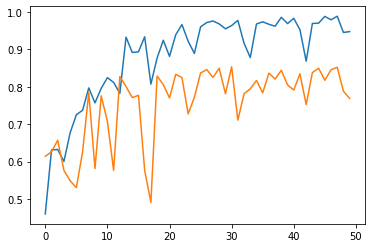

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [18]:
weights_cos = model.get_layer('cos').get_weights()[0].T.reshape(filters_cos.shape)
weights_sin = model.get_layer('sin').get_weights()[0].T.reshape(filters_sin.shape)

In [19]:
most_diff_indexes = np.argsort((weights_cos - filters_cos).var(axis=1))[::-1]

In [20]:
most_diff_indexes[:20]

array([219,  50,  37,  74, 122,  61, 206,  52,  66,  59, 119,  70,  67,
        77, 243, 213, 229,   6, 230,  75])

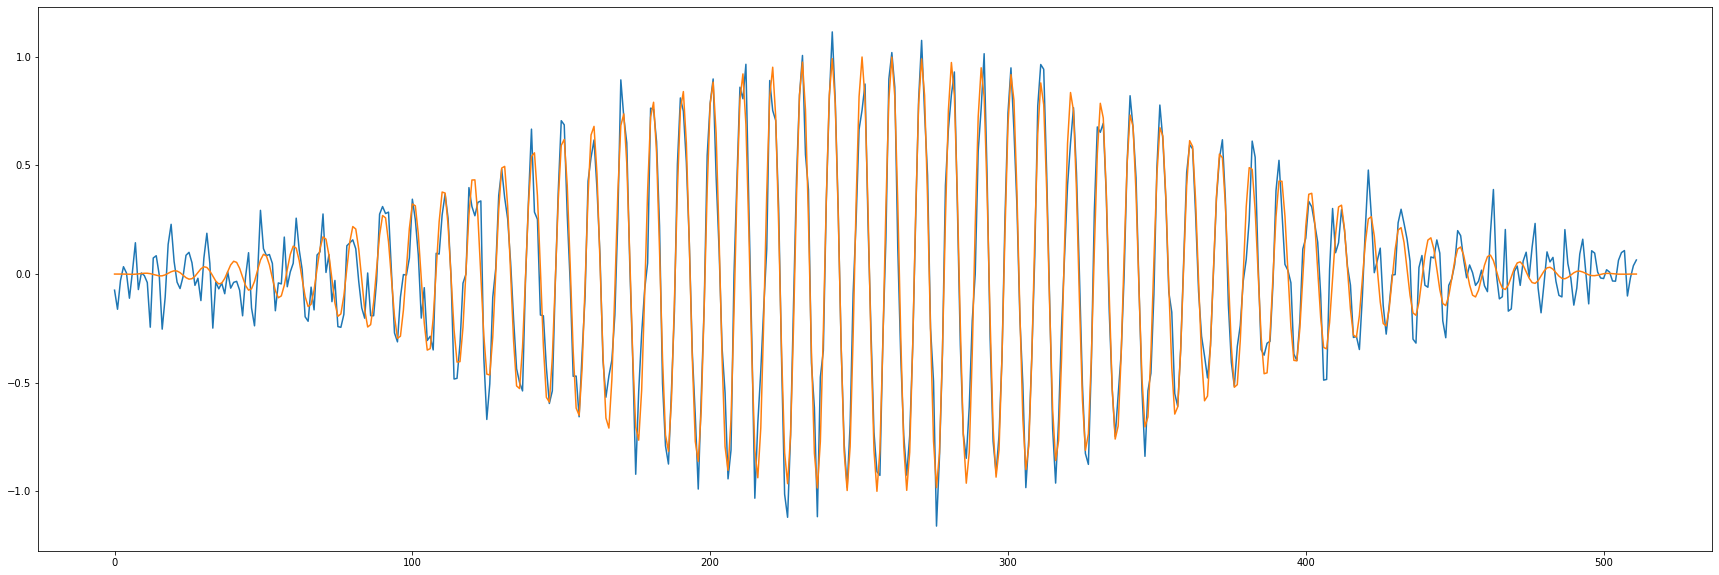

In [23]:
idx = 50
plt.figure(figsize=(30,10))
plt.plot(weights_cos[idx])
plt.plot(filters_cos[idx])

In [179]:
# x, sr, duration = get_train_clip(train[train['ebird_code']=='ameavo'].iloc[0])
# print(duration)

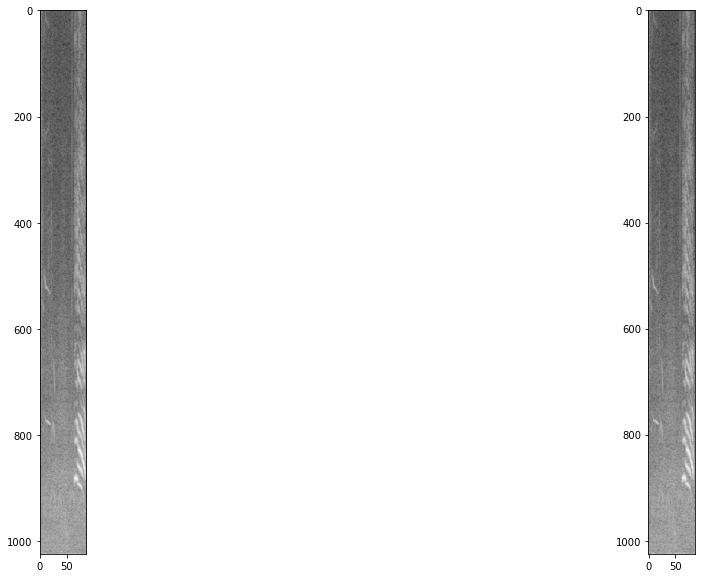

In [28]:
f, ax = plt.subplots(1, 2, figsize=(20,10))
# short time fourier transform
X = librosa.stft(X_train[0].reshape(-1))
# CNN output
y_fourier, y_class = model.predict(X_train[0:1])

ax[0].imshow(np.flipud(y_fourier.reshape(y_fourier.shape[1:]).T), cmap='gray')
ax[1].imshow(np.flipud(np.log(np.abs(X))), cmap='gray')
plt.show()

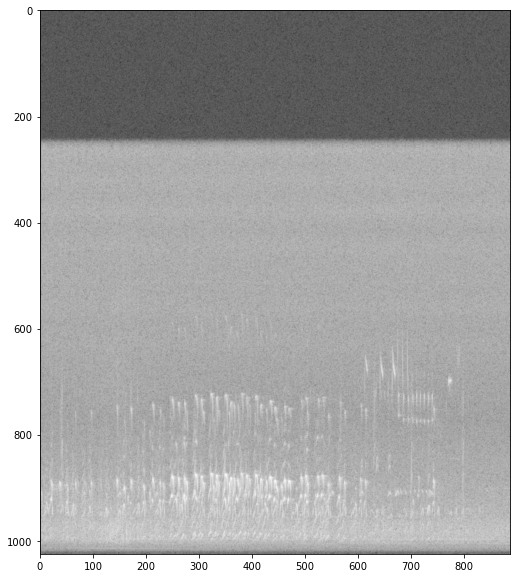